# Introduction

Talk briefly about the problem: which data do we have and which question do we want to solve.

The goal is "Based on individual trip attributes, participants should predict the duration of each trip in the test set."

Go in depth about the structure of your data: 2 datasets (one for training the other for analysis), and how are these datasets organized (shape, what can you find in each field/column).

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib
import matplotlib.pyplot as plt

# Fixing a bug that causes xgboost to kill the kernel in jupyter notebook on MacOS
# https://datascience.stackexchange.com/questions/33964/python-xgboost-killing-kernel
# https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Just checking that I can see plots in the jupyter notebook environment.
Check also http://nbviewer.jupyter.org/github/ipython/ipython/blob/6.x/examples/IPython%20Kernel/Plotting%20in%20the%20Notebook.ipynb

In [2]:
traindata = pd.read_csv("all/train.csv")
testdata = pd.read_csv("all/test.csv")

traindata.head()


id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

In [3]:
testdata.head()

id  vendor_id      pickup_datetime  passenger_count  \
0  id3004672          1  2016-06-30 23:59:58                1   
1  id3505355          1  2016-06-30 23:59:53                1   
2  id1217141          1  2016-06-30 23:59:47                1   
3  id2150126          2  2016-06-30 23:59:41                1   
4  id1598245          1  2016-06-30 23:59:33                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.988129        40.732029         -73.990173         40.756680   
1        -73.964203        40.679993         -73.959808         40.655403   
2        -73.997437        40.737583         -73.986160         40.729523   
3        -73.956070        40.771900         -73.986427         40.730469   
4        -73.970215        40.761475         -73.961510         40.755890   

  store_and_fwd_flag  
0                  N  
1                  N  
2                  N  
3                  N  
4                  N

Comparing time difference between pickup_datetime and dropoff_datetime in the train data set, we have that trip_duration is the duration of the trip in seconds. This is the observable we are interested in.



In [4]:
trainsumm = traindata.describe()
trainsumm

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01   9.594923e+02  
std         7.064327e-02      3.589056e-02   5.237432e+03  
min        -1.219333e+02      3.218114e+01   1.000000e+00  
25%        -7.399133e+01      4.073588e+01   3.970000e+02  
50%        -7.397975e+01      4.075452e+01   6.620000e+02  
75%        -7.396301e+01      4.076981e+01   1.075000e+03  
max        -6.133553e+01      4.392103e+01   3.526282e+06

In [5]:
testsumm = testdata.describe()
testsumm

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  625134.000000    625134.000000     625134.000000    625134.000000   
mean        1.534884         1.661765        -73.973614        40.750927   
std         0.498782         1.311293          0.073389         0.029848   
min         1.000000         0.000000       -121.933128        37.389587   
25%         1.000000         1.000000        -73.991852        40.737392   
50%         2.000000         1.000000        -73.981743        40.754093   
75%         2.000000         2.000000        -73.967400        40.768394   
max         2.000000         9.000000        -69.248917        42.814938   

       dropoff_longitude  dropoff_latitude  
count      625134.000000     625134.000000  
mean          -73.973458         40.751816  
std             0.072565          0.035824  
min          -121.933327         36.601322  
25%           -73.991318         40.736000  
50%           -73.979774         40.754543  
75%           -73.963013         40.769852  
max           -67.496796         48.857597

From these numbers we can quickly check "at first sight" whether the two data sets are comparable.
We see that in both datasets there are only 2 different companies taken into account (although we don't know if they are the same ones in both sets). Passenger mean and standard deviations are totally in agreement between both data sets (so the same type of cars have been used, at least in terms of capacity). And mean and standard deviations for longitudes and latitudes (pick ups and drop offs) are also in agreement. This very preliminar exploration is in agreement with a similar sampling of taxi trip events in NYC.

## Cleaning data
Checking for NAs and NANs.
Detecting artifacts and outlayers: in location, in trip durations (this latter only for the train set, of course).

In [6]:
# Checking for NaNs
# https://stackoverflow.com/questions/29530232/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe
#traindata.shape
traindata_nans = traindata.isnull().sum().sum().sum().sum().sum().sum().sum().sum().sum().sum().sum()
if (traindata_nans == 0):
    print "No NaNs detected in train data"
else:
    print "WARNING: NaNs detected in train data!!!"

#testdata.shape
testdata_nans = testdata.isnull().sum().sum().sum().sum().sum().sum().sum().sum().sum()
if (testdata_nans == 0):
    print "No NaNs detected in test data"
else:
    print "WARNING: NaNs detected in test data!!!"

# Checking for NAs
traindata_nas = traindata.isna().sum().sum().sum().sum().sum().sum().sum().sum().sum().sum().sum()
if (traindata_nas == 0):
    print "No NAs detected in train data"
else:
    print "WARNING: NAs detected in train data!!!"

testdata_nas = testdata.isna().sum().sum().sum().sum().sum().sum().sum().sum().sum()
if (testdata_nas == 0):
    print "No NAs detected in test data"
else:
    print "WARNING: NAs detected in test data!!!"

No NaNs detected in train data
No NaNs detected in test data
No NAs detected in train data
No NAs detected in test data


### Detecting artifacts and outlayers: in location 


In [7]:
traindata['pickup_longitude'].mean()
traindata['pickup_longitude'].min()

-121.93334197998048

In [8]:
import seaborn as sns
sns.set(style="darkgrid")

latlon_pick = traindata[['pickup_latitude', 'pickup_longitude']].values # returns a numpy array ~1.5E5 rows!!!
# https://pandas.pydata.org/pandas-docs/stable/indexing.html
# https://stackoverflow.com/questions/25876640/subsampling-every-nth-entry-in-a-numpy-array
latlon_pick_red = latlon_pick[0::1000] # start:stop:step (sampling our data for display)

# https://www.kaggle.com/daveianhickey/how-to-folium-for-maps-heatmaps-time-analysis
# https://stackoverflow.com/questions/39401729/plot-latitude-longitude-points-from-dataframe-on-folium-map-ipython
import folium
mapit = folium.Map( location=[traindata['pickup_latitude'].mean(), traindata['pickup_longitude'].mean()],
                   zoom_start=10 )

for coord in latlon_pick_red:
    folium.Marker(location=[coord[0], coord[1]]).add_to(mapit)

mapit.save( 'map_train_pick.html')

Viewing train data set pick up locations (sampled 1 every 1000 points for convenience). We seee here that most of the trips start in Manhattan, and there is also an important subset in JFK airport, and a less populated one in La Guardia airport.

In [9]:
mapit

In [10]:
mapit_drop = folium.Map( location=[traindata['dropoff_latitude'].mean(), traindata['dropoff_longitude'].mean()],
                   zoom_start=10 )
latlon_drop = traindata[['dropoff_latitude', 'dropoff_longitude']].values
latlon_drop_red = latlon_drop[0::1000] # start:stop:step (sampling our data for display)
for coord in latlon_drop_red:
    folium.Marker(location=[coord[0], coord[1]]).add_to(mapit_drop)

mapit.save( 'map_train_drop.html')

Drop offs in the train data set follow the same pattern as in pick ups. 

In [11]:
mapit_drop

Checking for direct distance distribution of trips in the train data set. I'm interested in seeing whether there are any outliers that could be artifacts. (compute direct distances and check outliers on the map). VAS PER AQUÍ!!!

Proceeding to compute direct distances between pick up and drop off coordinates, considering an ellipsoidal Earth.

In [12]:
# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
# https://pypi.org/project/geopy/
# https://chrisalbon.com/python/data_wrangling/pandas_create_column_with_loop/
import geopy.distance

latlon_all = traindata[['pickup_latitude','pickup_longitude','dropoff_latitude', 'dropoff_longitude']].values

distances = [] # creating a list to store distance results
for coord in latlon_all:
    distances.append(geopy.distance.vincenty([coord[0], coord[1]], [coord[2], coord[3]]).km)

# Create a new column in the train data set from the list (distance in km)
traindata['direct_dist'] = distances

Checking for outliers in trip distances, and where their corresponding coordinates are located in the map (pick up locations for outliers will be plotted in blue, dropoff locations will be plotted in red).

In [13]:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mean.html
#traindata.loc[:,'direct_dist']
direct_dist_mean = traindata['direct_dist'].mean()
direct_dist_std = traindata['direct_dist'].std()
direct_dist_mean

3.442192786742616

Mean direct distance for the train data set is 4 +- 4 km. Given that approx. distance between Manhattan and:
- La Guardia airport ~ 16 km
- JFK airport ~ 30 km
- Newark airport ~ 26-40 km (depending on the route)

We'll define outliers as all those values that are greater than 200 km.

In [14]:
direct_dist_threshold = 200 
direct_dist_outliers = traindata['direct_dist'] > direct_dist_threshold
direct_dist_outliers.sum()

11

And we find 11 possible outliers. Let's check them on the map (pick up locations for outliers will be plotted in blue, dropoff locations will be plotted in red).

In [15]:
# https://stackoverflow.com/questions/36202514/foilum-map-module-trying-to-get-more-options-for-marker-colors

latlon_outliers = traindata.loc[direct_dist_outliers,['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].values

mapit_outliers = folium.Map( location=[traindata['dropoff_latitude'].mean(), traindata['dropoff_longitude'].mean()],
                   zoom_start=4 )
for coord in latlon_outliers:
    folium.Marker(location=[coord[0], coord[1]], icon=folium.Icon(color='blue')).add_to(mapit_outliers)
    folium.Marker(location=[coord[2], coord[3]], icon=folium.Icon(color='red')).add_to(mapit_outliers)

mapit_outliers.save( 'map_train_outliers.html')

Some of the pick up/drop off events for these 11 outliers are located in the ocean. While other rides are more realistic (for instance, going from NYC to Washington DC, although the [cost of this trip](https://www.taxifarefinder.com/main.php?city=NY&from=Empire+State+Building%2C+350+5th+Ave%2C+New+York%2C+New+York+10118%2C+United+States&to=W+Washington+D.C.%2C+515+15th+St+NW%2C+Washington%2C+District+of+Columbia+20222%2C+United+States&fromCoord=40.74845,-73.98527&toCoord=38.897205,-77.033485) is around $700 which makes it highly improbable).

In [16]:
mapit_outliers   

I will 'mark' these outliers and check their corresponding durations (just out of curiosity). I will remove them from the train data set in order to avoid feeding the model with artifacts. 

In [17]:
traindata['dist_outliers'] = pd.Series(0, index=traindata.index)
# Set traindata['dist_outliers'] = 1 for direct_dist outliers only; this is, direct_dist_outliers
traindata.loc[direct_dist_outliers, 'dist_outliers'] = 1

# traindata['dist_outliers'].sum() # just checking

### Detecting artifacts and outlayers: in trip duration 

Only for the train data set, of course.
First, check that difference on timestamps for pick up and drop off events match exactly the computed trip duration column.
Next, check for outliers. Plotting trip durations as a function of direct distances, and colouring outliers for distances, should allow us to gain some insight into trip duration artifacts.

In [18]:
# traindata.loc[:5,['pickup_datetime']]
# https://stackoverflow.com/questions/1345827/how-do-i-find-the-time-difference-between-two-datetime-objects-in-python
# https://stackoverflow.com/questions/1345827/how-do-i-find-the-time-difference-between-two-datetime-objects-in-python
import datetime
from datetime import datetime

train_triptimedates = traindata.loc[:,['pickup_datetime','dropoff_datetime']].values

comp_duration = []
for timedat in train_triptimedates:
    #dummy = pd.Timedelta(datetime.strptime(timedat[1], '%Y-%m-%d %H:%M:%S') - datetime.strptime(timedat[0], '%Y-%m-%d %H:%M:%S')).seconds / 60.0
    dummy = pd.Timedelta(datetime.strptime(timedat[1], '%Y-%m-%d %H:%M:%S') - datetime.strptime(timedat[0], '%Y-%m-%d %H:%M:%S')).seconds
    comp_duration.append(dummy) # In seconds
    

We can see in the following graph that a few values for provided feature trip_duration, do not match our calculation based on time stamps provided in the pickup_datetime and dropoff_datetime features. 

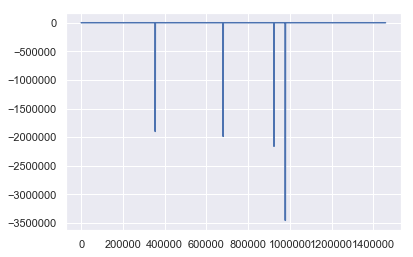

In [19]:
plt.plot(comp_duration - traindata.trip_duration)
#plt.title('A simple chirp')
plt.show()

In [20]:
from itertools import compress

mask = (comp_duration - traindata.trip_duration != 0)
comp_duration = np.array(comp_duration)
duration_problems_idxs = list(compress(xrange(len(mask)), mask))
comp_duration[duration_problems_idxs]

array([38936, 62378, 67612, 70282])

In [21]:
traindata.loc[duration_problems_idxs,['pickup_datetime','dropoff_datetime','trip_duration']]

pickup_datetime     dropoff_datetime  trip_duration
355003  2016-01-05 00:19:42  2016-01-27 11:08:38        1939736
680594  2016-02-13 22:38:00  2016-03-08 15:57:38        2049578
924150  2016-01-05 06:14:15  2016-01-31 01:01:07        2227612
978383  2016-02-13 22:46:52  2016-03-25 18:18:14        3526282

In [22]:
t0 = pd.Timestamp(traindata.loc[355003,['pickup_datetime']].values[0])
t1 = pd.Timestamp(traindata.loc[355003,['dropoff_datetime']].values[0])
print( 'Expected', (t1 - t0).total_seconds() )

('Expected', 1939736.0000000002)


Hence, it appears to be some kind of bug in pd.Timedelta() function. Just for coherence, we could use another way to compute trip duration, although [iterating over rows in a panda dataframe](https://stackoverflow.com/questions/7837722/what-is-the-most-efficient-way-to-loop-through-dataframes-with-pandas) can be really time consuming:

```
comp_duration = []

for index, row in traindata.iterrows():
    t0 = pd.Timestamp(traindata.loc[index,['pickup_datetime']].values[0])
    t1 = pd.Timestamp(traindata.loc[index,['dropoff_datetime']].values[0])
    dummy = (t1 - t0).total_seconds()
    comp_duration.append(dummy) # In seconds
    
comp_duration
```

I'm concluding then that trip_duration provided with train data set is correct. I am going to consider as outliers/artifacts those trips whose duration exceed 24h.

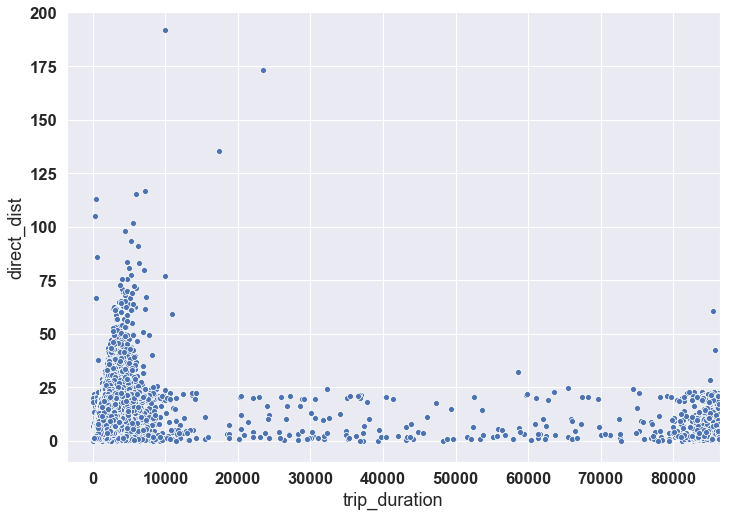

In [170]:
# https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.set(rc={'figure.figsize':(11.7,8.27)},font_scale=1.5)
ax = sns.scatterplot(x="trip_duration", y="direct_dist", data=traindata)

# Setting axes limis
ax.set_xlim(-3600,86400)
ax.set_ylim(-10,200) #-10,200 km

# Show the plot
plt.show()

From the previous graph, we can see there are quite a number of outliers/artifacts regarding trip duration. I'm going to discard those trips whose:
- duration is less than 2 minutes and larger or equal than 24 hours
- direct distance is less or equal than 100 m and larger than 200 km

In [24]:
# Converting pick up and drop off dates to datetime

# https://stackoverflow.com/questions/37042922/datetime-strptime-in-python-pandas-whats-wrong
traindata['pickup_Dates'] = pd.to_datetime(traindata['pickup_datetime'])
traindata['dropoff_Dates'] = pd.to_datetime(traindata['dropoff_datetime'])

In [25]:
trainclean = traindata
# https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression
trainclean = trainclean.drop(trainclean[(trainclean.trip_duration < 120) | (trainclean.trip_duration >= 86400)].index)
trainclean = trainclean.drop(trainclean[(trainclean.direct_dist <= 0.1) | (trainclean.direct_dist > 200)].index)


In [26]:
trainclean.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  direct_dist  \
0         40.765602                  N            455     1.502172   
1         40.731152                  N            663     1.808660   
2         40.710087                  N           2124     6.379687   
3         40.706718                  N            429     1.483632   
4         40.782520                  N            435     1.187038   

   dist_outliers        pickup_Dates       dropoff_Dates  
0              0 2016-03-14 17:24:55 2016-03-14 17:32:30  
1              0 2016-06-12 00:43:35 2016-06-12 00:54:38  
2              0 2016-01-19 11:35:24 2016-01-19 12:10:48  
3              0 2016-04-06 19:32:31 2016-04-06 19:39:40  
4              0 2016-03-26 13:30:55 2016-03-26 13:38:10

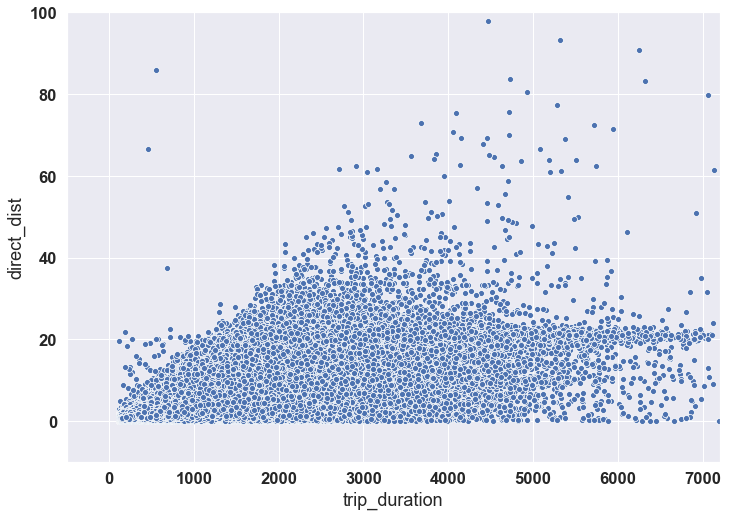

In [171]:
sns.set(rc={'figure.figsize':(11.7,8.27)},font_scale=1.5)
ax2 = sns.scatterplot(x="trip_duration", y="direct_dist", data=trainclean)

# Setting axes limits
ax2.set_xlim(-500,7200) # 2 hours
ax2.set_ylim(-10,100)

# Show the plot
plt.show()

There seem to be two interesting events here. The first one, is that there is a marked clean linear dependence between 
direct_dist and trip_duration (as expected) (see triangle whose hypotenuse goes from (0,0) to ~(1000s, 20km)). The second one is that there appears to be a saturation at direct_dist equal to 20 km. This might be due to rush hour traffic delays that have a special impact in trips with a that characteristic effective distance.

Let's check whether we can create a rush hour feature. To do so, I will compute an effective speed (=direct_dist/trip_duration) in an hourly manner during the day, and discriminating the day of the week. These data should give us a hint whether there is a well defined time frame in which the effective speeds significantly drops due to a high traffic load.

In [28]:
trainclean.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  direct_dist  \
0         40.765602                  N            455     1.502172   
1         40.731152                  N            663     1.808660   
2         40.710087                  N           2124     6.379687   
3         40.706718                  N            429     1.483632   
4         40.782520                  N            435     1.187038   

   dist_outliers        pickup_Dates       dropoff_Dates  
0              0 2016-03-14 17:24:55 2016-03-14 17:32:30  
1              0 2016-06-12 00:43:35 2016-06-12 00:54:38  
2              0 2016-01-19 11:35:24 2016-01-19 12:10:48  
3              0 2016-04-06 19:32:31 2016-04-06 19:39:40  
4              0 2016-03-26 13:30:55 2016-03-26 13:38:10

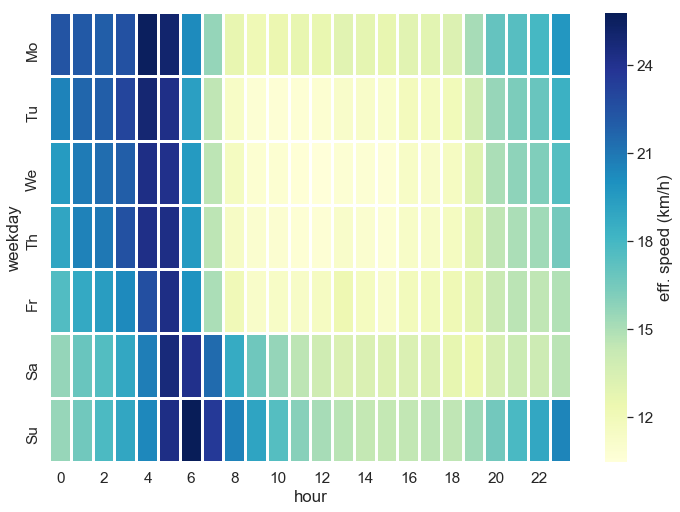

In [29]:
# Defining eff_speed (in km/h)
trainclean['eff_speed'] = pd.Series(3600*trainclean['direct_dist']/trainclean['trip_duration'], index=trainclean.index)
# Day of the week: Monday is 0 and Sunday is 6
trainclean['weekday'] = trainclean['pickup_Dates'].dt.dayofweek 
trainclean['hour'] = trainclean['pickup_Dates'].dt.hour
trainclean['month'] = trainclean['pickup_Dates'].dt.month

# https://stackoverflow.com/questions/30328646/python-pandas-group-by-in-group-by-and-average
speedmapdata = trainclean.groupby(['weekday', 'hour'], as_index=False).mean()

# Pivoting data (https://stackoverflow.com/questions/37790429/seaborn-heatmap-using-pandas-dataframe)
pivotedspeedmapdata = speedmapdata.pivot(index='weekday', columns='hour', values='eff_speed')
sns.set(font_scale=1.4)
ax = sns.heatmap(pivotedspeedmapdata, xticklabels=2, cmap="YlGnBu",linewidths=2, linecolor='white',\
                 yticklabels=['Mo','Tu','We','Th','Fr','Sa','Su'], cbar_kws={'label': 'eff. speed (km/h)'})

From this heatmap we can see a significant drop in the effective speed from Monday to Friday in the time range from 8am to 6pm. The effective speed, although it's not a real speed (because it was computed with the direct distance, which is equal to computing the distance between two coordinates in the Earth surface and thus does not correspond to the real trajectory the taxi followed), is a good indicator for the rush hour: the time of day for which traffic in NYC affects flow. 

Thus, I will create a new feature: rush_hour, that will take into account whether the pick up took place during a rush hour time frame.

In [30]:
trainclean['rush_hour'] = pd.Series(0, index=trainclean.index)
mask = (trainclean['weekday']<=4) & (trainclean['hour']>=8) &(trainclean['hour']<=18)
trainclean.loc[mask, 'rush_hour'] = 1

We can now check where in the previous graph (direct_dist as function of trip_duration) rush hour trips fall.

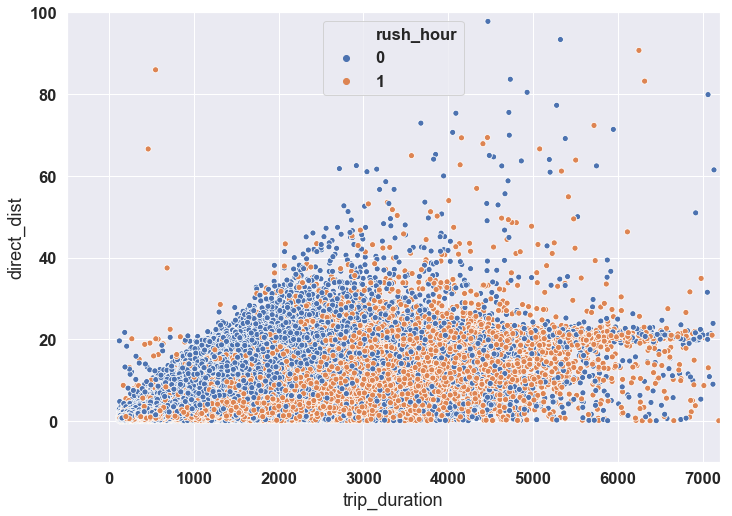

In [172]:
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.5)
ax3 = sns.scatterplot(x="trip_duration", y="direct_dist", hue="rush_hour", data=trainclean)

# Setting axes limits
ax3.set_xlim(-500,7200) # 2 hours
ax3.set_ylim(-10,100)

# Show the plot
plt.show()

We can clearly see here how trips corresponding to rush hour pick ups deviate from the linear relation between distance and duration. Note also that the "saturation line" (at direct_dist = 20 km) is mostly defined by rush hour trips, as we speculated.

Regarding locations, we can differentiate between trips to and from airports (La Guardia, JFK, and Newark) from the rest. I will add LG_airport, JFK_airport, and EWR_airport features to train data set, checking for pick up/drop off locations at a distance radius within 3 km from these airports.

In [32]:
LG_location = np.array([40.7769, -73.8740]) # latitude, longitude
JFK_location = np.array([40.6413, -73.7781])
EWR_location = np.array([40.6895, -74.1745]) 
radius = 3 # In km

# Checking on the map
mapit_airports = folium.Map( location=[traindata['dropoff_latitude'].mean(), traindata['dropoff_longitude'].mean()],
                   zoom_start=11 )

folium.Marker(location=[LG_location[0], LG_location[1]], icon=folium.Icon(color='blue')).add_to(mapit_airports)
folium.Marker(location=[JFK_location[0], JFK_location[1]], icon=folium.Icon(color='red')).add_to(mapit_airports)
folium.Marker(location=[EWR_location[0], EWR_location[1]], icon=folium.Icon(color='green')).add_to(mapit_airports)

mapit_airports

In [33]:
# Looking for pick up locations within 3 km radius distance from these 3 airports
clean_latlon_all = trainclean[['pickup_latitude','pickup_longitude','dropoff_latitude', 'dropoff_longitude']].values

LGdistancesPU = [] # creating a list to store pick up distance from LG airport results
LGdistancesDO = [] # idem for drop off
JFKdistancesPU = []
JFKdistancesDO = []
EWRdistancesPU = []
EWRdistancesDO = []
for coord in clean_latlon_all:
    LGdistancesPU.append(geopy.distance.vincenty([coord[0], coord[1]], [LG_location[0], LG_location[1]]).km)
    LGdistancesDO.append(geopy.distance.vincenty([coord[2], coord[3]], [LG_location[0], LG_location[1]]).km)
    JFKdistancesPU.append(geopy.distance.vincenty([coord[0], coord[1]], [JFK_location[0], JFK_location[1]]).km)
    JFKdistancesDO.append(geopy.distance.vincenty([coord[2], coord[3]], [JFK_location[0], JFK_location[1]]).km)
    EWRdistancesPU.append(geopy.distance.vincenty([coord[0], coord[1]], [EWR_location[0], EWR_location[1]]).km)
    EWRdistancesDO.append(geopy.distance.vincenty([coord[2], coord[3]], [EWR_location[0], EWR_location[1]]).km)

    
LGdistancesPU = np.array(JFKdistancesPU)
LGdistancesDO = np.array(LGdistancesDO)
JFKdistancesPU = np.array(JFKdistancesPU)
JFKdistancesDO = np.array(JFKdistancesDO)
EWRdistancesPU = np.array(EWRdistancesPU)
EWRdistancesDO = np.array(EWRdistancesDO)

trainclean['LG_airport'] = pd.Series(0, index=trainclean.index)
trainclean['JFK_airport'] = pd.Series(0, index=trainclean.index)
trainclean['EWR_airport'] = pd.Series(0, index=trainclean.index)

trainclean.loc[LGdistancesPU <= radius,'LG_airport'] = 1
trainclean.loc[JFKdistancesPU <= radius,'JFK_airport'] = 1
trainclean.loc[EWRdistancesPU <= radius,'EWR_airport'] = 1
trainclean.loc[LGdistancesDO <= radius,'LG_airport'] = 1
trainclean.loc[JFKdistancesDO <= radius,'JFK_airport'] = 1
trainclean.loc[EWRdistancesDO <= radius,'EWR_airport'] = 1

Just checking that distance outliers have definitely been removed.

In [34]:
trainclean.dist_outliers.sum()

0

Checking the effect of number of passengers in trip duration.

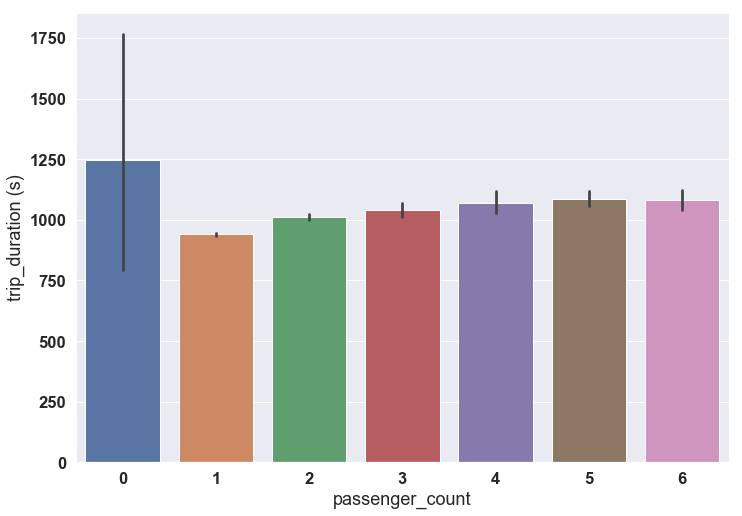

In [169]:
ax = sns.barplot(x=trainclean['passenger_count'], y=trainclean['trip_duration'])
ax.set(xlabel='passenger_count', ylabel='trip_duration (s)')
plt.show()

The first column (0 passengers) is per se a weird data. Although it is a bit difficult to justify (an empty taxi billing for the trip), maybe it is due to taxi/service booking (could the higher trip duration be due to waiting time until the passenger appears?). I'm not going to remove 0 passenger data, nor I'm going to include this feature in the model. 

## Considering external data

There are different events that can have a huge impact in a city traffic flow. This is the case of adverse weather conditions (snow, ice, rain, etc.), road conditions (accidents and road works), last minute Christmas shopping (holiday calendar), among others. Here I don't have time to look for car accidents and road works in NYC during the considered period of time of our data. But this is something one could (and should!) take into account if a more precise prediction was needed.

### Weather conditions
There is a data set on weather conditions in NYC on 2016 submitted by user [Mathijs Waegemakers](https://www.kaggle.com/mathijs) that can be found [here](https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016). For each day, it contains the maximum, minimum, and average temperature (in Fahrenheit degrees), rain precipitacion (in inches per square mile), snow fall (in inches), and previous accumulated snow (in inches). For these last 3 features, a "T" can be found indicating "traces".

In [35]:
weather = pd.read_csv("all/weather_data_nyc_centralpark_2016.csv")
weather.head(30)

date  maximum temerature  minimum temperature  average temperature  \
0   01-01-16                  44                   34                 39.0   
1   02-01-16                  40                   30                 35.0   
2   03-01-16                  46                   33                 39.5   
3   04-01-16                  35                   13                 24.0   
4   05-01-16                  29                   10                 19.5   
5   06-01-16                  41                   16                 28.5   
6   07-01-16                  43                   20                 31.5   
7   08-01-16                  46                   29                 37.5   
8   09-01-16                  47                   37                 42.0   
9   10-01-16                  60                   42                 51.0   
10  11-01-16                  42                   26                 34.0   
11  12-01-16                  44                   22                 33.0   
12  13-01-16                  31                   24                 27.5   
13  14-01-16                  36                   22                 29.0   
14  15-01-16                  46                   30                 38.0   
15  16-01-16                  52                   39                 45.5   
16  17-01-16                  43                   28                 35.5   
17  18-01-16                  30                   20                 25.0   
18  19-01-16                  30                   19                 24.5   
19  20-01-16                  40                   25                 32.5   
20  21-01-16                  38                   24                 31.0   
21  22-01-16                  30                   18                 24.0   
22  23-01-16                  30                   25                 27.5   
23  24-01-16                  36                   18                 27.0   
24  25-01-16                  37                   22                 29.5   
25  26-01-16                  45                   23                 34.0   
26  27-01-16                  46                   28                 37.0   
27  28-01-16                  43                   24                 33.5   
28  29-01-16                  43                   31                 37.0   
29  30-01-16                  40                   26                 33.0   

   precipitation snow fall snow depth  
0              0         0          0  
1              0         0          0  
2              0         0          0  
3              0         0          0  
4              0         0          0  
5              0         0          0  
6              0         0          0  
7              0         0          0  
8              0         0          0  
9           1.23         0          0  
10             0         0          0  
11          0.01         T          0  
12             0         0          0  
13             T       0.1          0  
14             T         0          0  
15          0.27         0          0  
16          0.04       0.7          0  
17             T         T          1  
18             0         0          T  
19             0         0          0  
20             0         0          0  
21             0         0          0  
22          0.69       9.5          T  
23          0.02         T         10  
24             0         0          9  
25             T         0          8  
26             T         0          5  
27             0         0          2  
28             T         0          2  
29             0         0          1

Changing all units to SI and "T" to a small quantity (0.25 mm/h as explained [here](https://en.wikipedia.org/wiki/Rain_gauge)). For convenience, I will also relabel fields. Despite for this problem we strictly don't need to change units to SI, I do not recommend to have a code using different unit systems. For this prediction we are not going to compute anything with the weather variables that use the Imperial unit system. However, someone could pick this project up where I left it, assume that everything is in good shape, and then proceed to her own analysis mixing units. That calls for disaster, as happened with [NASA's satellite that got lost](http://edition.cnn.com/TECH/space/9909/30/mars.metric/) due to mixing metric systems. 

In [36]:
# Function to convert Fahrenheit to Celsius 
# (input f = temperature in Fahrenheit, returns c = temperature in Celsius)
# http://ucsdlib.github.io/win2016-python-gps/functions-pandas.html

def fahr_to_celsius(temp_fahr):
    """Convert Fahrenheit to Celsius
    
    Return Celsius conversion of input"""
    temp_celsius = (temp_fahr - 32) * 5 / 9
    return temp_celsius


weather = weather.rename(index=str, columns={"maximum temerature": "max_temp", "minimum temperature": "min_temp", \
                                   "average temperature":"avg_temp", "precipitation":"rain", \
                                   "snow fall":"snow_fall", "snow depth":"snow_acc"})

weather.max_temp = fahr_to_celsius(weather["max_temp"]) 
weather.min_temp = fahr_to_celsius(weather["min_temp"])
weather.avg_temp = fahr_to_celsius(weather["avg_temp"])


# For rain, snow_fall, and snow_acc changing "T"s for 0.01 inches (0.25 mm), and converting inches 
# to mm (1 inch = 25.4 mm) 
weather.loc[weather['rain'].str.match('T'),('rain')] = 0.01
weather.rain = weather.rain.astype(float)
weather.loc[weather['snow_fall'].str.match('T'),('snow_fall')] = 0.01
weather.snow_fall = weather.snow_fall.astype(float)
weather.loc[weather['snow_acc'].str.match('T'),('snow_acc')] = 0.01
weather.snow_acc = weather.snow_acc.astype(float)

weather.rain = weather.rain*25.4 # In mm
weather.snow_fall = weather.snow_fall*25.4 # In mm
weather.snow_acc = weather.snow_acc*25.4 # In mm

# Checking for NaNs
# https://stackoverflow.com/questions/29530232/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe
weather.isnull().sum().sum()

# Checking for NAs
weather.isna().sum().sum()

weather.head(30)

date   max_temp   min_temp   avg_temp    rain  snow_fall  snow_acc
0   01-01-16   6.666667   1.111111   3.888889   0.000      0.000     0.000
1   02-01-16   4.444444  -1.111111   1.666667   0.000      0.000     0.000
2   03-01-16   7.777778   0.555556   4.166667   0.000      0.000     0.000
3   04-01-16   1.666667 -10.555556  -4.444444   0.000      0.000     0.000
4   05-01-16  -1.666667 -12.222222  -6.944444   0.000      0.000     0.000
5   06-01-16   5.000000  -8.888889  -1.944444   0.000      0.000     0.000
6   07-01-16   6.111111  -6.666667  -0.277778   0.000      0.000     0.000
7   08-01-16   7.777778  -1.666667   3.055556   0.000      0.000     0.000
8   09-01-16   8.333333   2.777778   5.555556   0.000      0.000     0.000
9   10-01-16  15.555556   5.555556  10.555556  31.242      0.000     0.000
10  11-01-16   5.555556  -3.333333   1.111111   0.000      0.000     0.000
11  12-01-16   6.666667  -5.555556   0.555556   0.254      0.254     0.000
12  13-01-16  -0.555556  -4.444444  -2.500000   0.000      0.000     0.000
13  14-01-16   2.222222  -5.555556  -1.666667   0.254      2.540     0.000
14  15-01-16   7.777778  -1.111111   3.333333   0.254      0.000     0.000
15  16-01-16  11.111111   3.888889   7.500000   6.858      0.000     0.000
16  17-01-16   6.111111  -2.222222   1.944444   1.016     17.780     0.000
17  18-01-16  -1.111111  -6.666667  -3.888889   0.254      0.254    25.400
18  19-01-16  -1.111111  -7.222222  -4.166667   0.000      0.000     0.254
19  20-01-16   4.444444  -3.888889   0.277778   0.000      0.000     0.000
20  21-01-16   3.333333  -4.444444  -0.555556   0.000      0.000     0.000
21  22-01-16  -1.111111  -7.777778  -4.444444   0.000      0.000     0.000
22  23-01-16  -1.111111  -3.888889  -2.500000  17.526    241.300     0.254
23  24-01-16   2.222222  -7.777778  -2.777778   0.508      0.254   254.000
24  25-01-16   2.777778  -5.555556  -1.388889   0.000      0.000   228.600
25  26-01-16   7.222222  -5.000000   1.111111   0.254      0.000   203.200
26  27-01-16   7.777778  -2.222222   2.777778   0.254      0.000   127.000
27  28-01-16   6.111111  -4.444444   0.833333   0.000      0.000    50.800
28  29-01-16   6.111111  -0.555556   2.777778   0.254      0.000    50.800
29  30-01-16   4.444444  -3.333333   0.555556   0.000      0.000    25.400

On January 22-23 2016, there was [the biggest blizzards to hit the NYC](https://www.nbcnewyork.com/news/local/NYC-New-York-City-Blizzard-Biggest-Ever-January-23-2016-377435221.html) since the weather records started in the late 19-th century. A [travel ban](https://www.governor.ny.gov/news/governor-cuomo-declares-state-emergency-new-york-city-long-island-and-lower-hudson-valley) was issued from Sat 01/23 to Sun 01/24. After that, I remember the following days were a real mess (I just arrived to my new home in Bethlehem, PA, which is only 80 miles from Manhattan, 5 days before the blizzard). As this is a special case I'm going to create a new feature for this event. 

In [37]:
weather['blizzard'] = pd.Series(0, index=weather.index)
# Set blizzard to 1 during the period from Jan 23 to Jan 29
# https://stackoverflow.com/questions/29370057/select-dataframe-rows-between-two-dates
# https://stackoverflow.com/questions/21608228/conditional-replace-pandas/48795837
# https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea
weather['dateOK'] = pd.date_range(start='01/01/2016', end='31/12/2016')
mask = (weather['dateOK'] >= '23/01/2016') & (weather['dateOK'] <= '29/01/2016')
weather.loc[mask, 'blizzard'] = 1

weather.head(30)

date   max_temp   min_temp   avg_temp    rain  snow_fall  snow_acc  \
0   01-01-16   6.666667   1.111111   3.888889   0.000      0.000     0.000   
1   02-01-16   4.444444  -1.111111   1.666667   0.000      0.000     0.000   
2   03-01-16   7.777778   0.555556   4.166667   0.000      0.000     0.000   
3   04-01-16   1.666667 -10.555556  -4.444444   0.000      0.000     0.000   
4   05-01-16  -1.666667 -12.222222  -6.944444   0.000      0.000     0.000   
5   06-01-16   5.000000  -8.888889  -1.944444   0.000      0.000     0.000   
6   07-01-16   6.111111  -6.666667  -0.277778   0.000      0.000     0.000   
7   08-01-16   7.777778  -1.666667   3.055556   0.000      0.000     0.000   
8   09-01-16   8.333333   2.777778   5.555556   0.000      0.000     0.000   
9   10-01-16  15.555556   5.555556  10.555556  31.242      0.000     0.000   
10  11-01-16   5.555556  -3.333333   1.111111   0.000      0.000     0.000   
11  12-01-16   6.666667  -5.555556   0.555556   0.254      0.254     0.000   
12  13-01-16  -0.555556  -4.444444  -2.500000   0.000      0.000     0.000   
13  14-01-16   2.222222  -5.555556  -1.666667   0.254      2.540     0.000   
14  15-01-16   7.777778  -1.111111   3.333333   0.254      0.000     0.000   
15  16-01-16  11.111111   3.888889   7.500000   6.858      0.000     0.000   
16  17-01-16   6.111111  -2.222222   1.944444   1.016     17.780     0.000   
17  18-01-16  -1.111111  -6.666667  -3.888889   0.254      0.254    25.400   
18  19-01-16  -1.111111  -7.222222  -4.166667   0.000      0.000     0.254   
19  20-01-16   4.444444  -3.888889   0.277778   0.000      0.000     0.000   
20  21-01-16   3.333333  -4.444444  -0.555556   0.000      0.000     0.000   
21  22-01-16  -1.111111  -7.777778  -4.444444   0.000      0.000     0.000   
22  23-01-16  -1.111111  -3.888889  -2.500000  17.526    241.300     0.254   
23  24-01-16   2.222222  -7.777778  -2.777778   0.508      0.254   254.000   
24  25-01-16   2.777778  -5.555556  -1.388889   0.000      0.000   228.600   
25  26-01-16   7.222222  -5.000000   1.111111   0.254      0.000   203.200   
26  27-01-16   7.777778  -2.222222   2.777778   0.254      0.000   127.000   
27  28-01-16   6.111111  -4.444444   0.833333   0.000      0.000    50.800   
28  29-01-16   6.111111  -0.555556   2.777778   0.254      0.000    50.800   
29  30-01-16   4.444444  -3.333333   0.555556   0.000      0.000    25.400   

    blizzard     dateOK  
0          0 2016-01-01  
1          0 2016-01-02  
2          0 2016-01-03  
3          0 2016-01-04  
4          0 2016-01-05  
5          0 2016-01-06  
6          0 2016-01-07  
7          0 2016-01-08  
8          0 2016-01-09  
9          0 2016-01-10  
10         0 2016-01-11  
11         0 2016-01-12  
12         0 2016-01-13  
13         0 2016-01-14  
14         0 2016-01-15  
15         0 2016-01-16  
16         0 2016-01-17  
17         0 2016-01-18  
18         0 2016-01-19  
19         0 2016-01-20  
20         0 2016-01-21  
21         0 2016-01-22  
22         1 2016-01-23  
23         1 2016-01-24  
24         1 2016-01-25  
25         1 2016-01-26  
26         1 2016-01-27  
27         1 2016-01-28  
28         1 2016-01-29  
29         0 2016-01-30

Adding weather features precipitation (=rain + snow_fall), with_snow (=snow_fall + snow_acc), blizzard, max/min/average temperatures to trainclean.

In [38]:
trainclean['blizzard'] = pd.Series(0, index=trainclean.index)
trainclean['rain'] = pd.Series(0, index=trainclean.index)
trainclean['snow_fall'] = pd.Series(0, index=trainclean.index)
trainclean['snow_acc'] = pd.Series(0, index=trainclean.index)
trainclean['max_temp'] = pd.Series(0, index=trainclean.index)
trainclean['min_temp'] = pd.Series(0, index=trainclean.index)
trainclean['avg_temp'] = pd.Series(0, index=trainclean.index)
trainclean['is_rain'] = pd.Series(0, index=trainclean.index)
trainclean['is_snow'] = pd.Series(0, index=trainclean.index)

for idx in weather.index:
    mask = (weather.loc[idx,'dateOK'].dayofyear == trainclean['pickup_Dates'].dt.dayofyear)
    trainclean.loc[mask, 'blizzard'] = weather.loc[idx,'blizzard']
    trainclean.loc[mask, 'rain'] = weather.loc[idx,'rain']
    trainclean.loc[mask, 'snow_fall'] = weather.loc[idx,'snow_fall']
    trainclean.loc[mask, 'snow_acc'] = weather.loc[idx,'snow_acc']
    trainclean.loc[mask, 'max_temp'] = weather.loc[idx,'max_temp']
    trainclean.loc[mask, 'min_temp'] = weather.loc[idx,'min_temp']
    trainclean.loc[mask, 'avg_temp'] = weather.loc[idx,'avg_temp']

trainclean['precipitation'] = trainclean['rain'] + trainclean['snow_fall']

mask = (trainclean['rain'] > 0)
trainclean.loc[mask, 'is_rain'] = 1

mask = (trainclean['snow_fall'] > 0) | (trainclean['snow_acc'] > 0)
trainclean.loc[mask, 'is_snow'] = 1

Visualizing the impact of weather on trip duration.

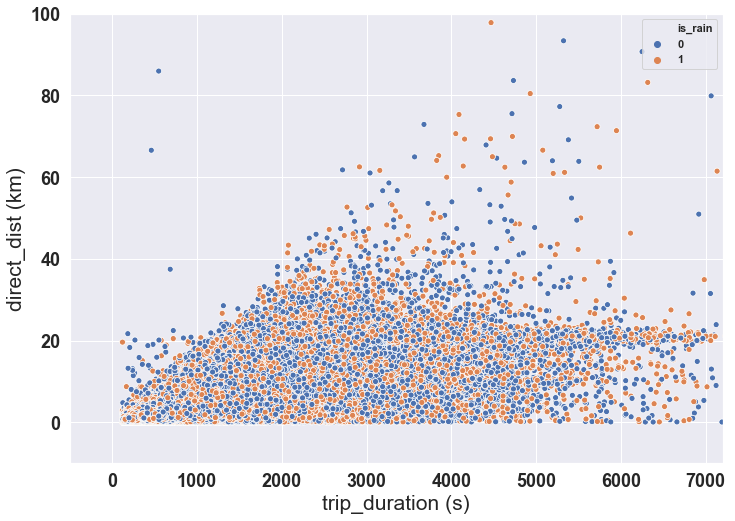

In [153]:
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.5)
#sborn.set(font_scale=1.5)
ax4 = sns.scatterplot(x="trip_duration", y="direct_dist", hue="is_rain", data=trainclean)
#ax4.axes.set_title("Title",fontsize=50)
ax4.set_xlabel("trip_duration (s)",fontsize=21)
ax4.set_ylabel("direct_dist (km)",fontsize=21)
ax4.tick_params(labelsize=18)

# Setting axes limits
ax4.set_xlim(-500,7200) # 2 hours
ax4.set_ylim(-10,100)

# Show the plot
plt.show()

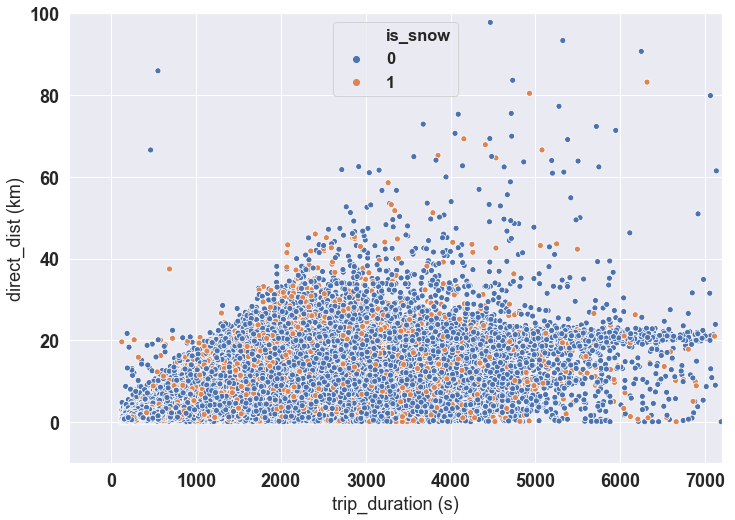

In [154]:
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.5)
#sborn.set(font_scale=1.5)
ax4 = sns.scatterplot(x="trip_duration", y="direct_dist", hue="is_snow", data=trainclean)
#ax4.axes.set_title("Title",fontsize=50)
ax4.set_xlabel("trip_duration (s)")
ax4.set_ylabel("direct_dist (km)")
ax4.tick_params(labelsize=18)

# Setting axes limits
ax4.set_xlim(-500,7200) # 2 hours
ax4.set_ylim(-10,100)

# Show the plot
plt.show()

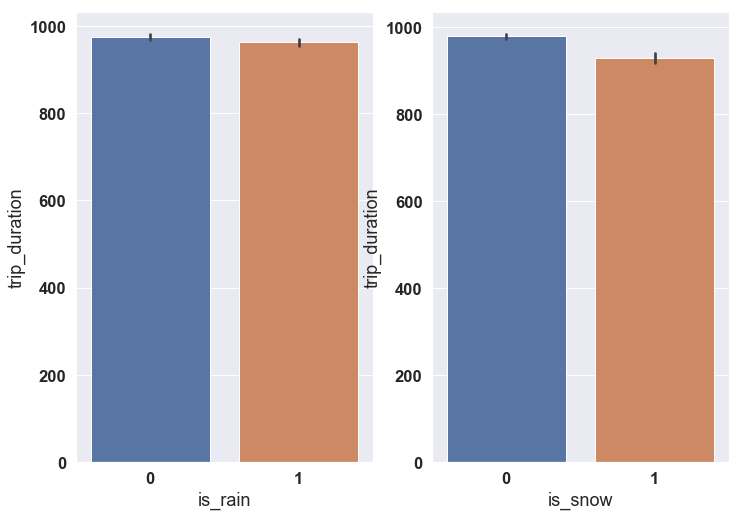

In [167]:
# Create a figure instance, and the two subplots
fig = plt.figure()
axw1 = fig.add_subplot(121) #211
axw2 = fig.add_subplot(122) #212
sns.barplot(x=trainclean['is_rain'], y=trainclean['trip_duration'], ax=axw1)
axw1.set(xlabel='is_rain', ylabel='trip_duration (s)')
sns.barplot(x=trainclean['is_snow'], y=trainclean['trip_duration'], ax=axw2)
axw2.set(xlabel='is_snow', ylabel='trip_duration (s)')
plt.show()

These graphs do not show any obvious pattern / correlation between trip_duration and rain events, although there seems to be an effect of snow events in trip duration. The impact of rain and snow could be masked here due to "binarization" of data for visualitzation purposes (using is_rain, is_snow, instead of proper measurements of precipitation). I'm going to include the precipitation and blizzard features in the model instead of is_rain, is_snow. 

### Realistic routes (No time for this right now)
There is a data set developed by the kaggle user [oscarleo](https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm) but I'm not going to use it because I'm running out of time. However, I need to warn you that this information could significantly change the effective speed we computed before, and thus change the insight we gained about the rush hour. In this case though, common sense/experience indicates that our estimation of the rush hour is highly realistic.


### Holidays calendar 
Considering only Federal US holidays. 

In [39]:
# https://stackoverflow.com/questions/2394235/detecting-a-us-holiday
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2016-01-01', end='2016-12-31').to_pydatetime()
holidays = pd.to_datetime(holidays)
holidays.dayofyear

trainclean['holiday'] = pd.Series(0, index=trainclean.index)

for fest in holidays:
    mask = (fest.dayofyear == trainclean['pickup_Dates'].dt.dayofyear)
    trainclean.loc[mask, 'holiday'] = 1


Creating a new data frame containing only all relevant features that we might be willing to consider in the model.

In [40]:
list(trainclean)

['id',
 'vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'trip_duration',
 'direct_dist',
 'dist_outliers',
 'pickup_Dates',
 'dropoff_Dates',
 'eff_speed',
 'weekday',
 'hour',
 'month',
 'rush_hour',
 'LG_airport',
 'JFK_airport',
 'EWR_airport',
 'blizzard',
 'rain',
 'snow_fall',
 'snow_acc',
 'max_temp',
 'min_temp',
 'avg_temp',
 'is_rain',
 'is_snow',
 'precipitation',
 'holiday']

Visualizing store_and_fwd_flag, passenger_count, and vendor_id features on trip duration.

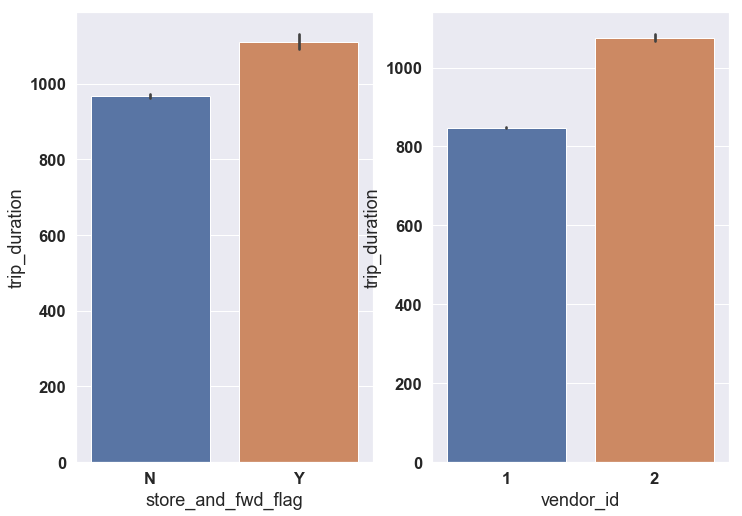

In [166]:
# Bar plots

# Create a figure instance, and the two subplots
fig = plt.figure()
axv1 = fig.add_subplot(121) #211
axv2 = fig.add_subplot(122) #212

# Flag
#train_flag = trainclean.groupby([trainclean['store_and_fwd_flag']])['trip_duration'].mean()
#train_flag = train_flag.reset_index()
#sns.barplot(x='store_and_fwd_flag', y='trip_duration', data=train_flag, ax=axv1)
sns.barplot(x=trainclean['store_and_fwd_flag'], y=trainclean['trip_duration'], ax=axv1)

# Vendor id
#train_vid = trainclean.groupby([trainclean['vendor_id']])['trip_duration'].mean()
#train_vid = train_vid.reset_index()
#sns.barplot(x='vendor_id', y='trip_duration', data=train_vid, ax=axv2)
sns.barplot(x=trainclean['vendor_id'], y=trainclean['trip_duration'], ax=axv2)

# Number of passengers

Selecting the following features for a first exploration round: vendor_id, passenger_count, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, store_and_fwd_flag, trip_duration, direct_dist, pickup_Dates, dropoff_Dates, LG_airport, JFK_airport, EWR_airport', eff_speed, weekday, hour, rush_hour, blizzard, rain, snow_fall, snow_acc, max_temp, min_temp, avg_temp, holiday, month, precipitation, is_rain, is_snow. This is, dropping id, pickup_datetime, dropoff_datetime, dist_outliers.

In [41]:
trainfinal = trainclean
trainfinal = trainfinal.drop(columns=['id', 'pickup_datetime', 'dropoff_datetime', 'dist_outliers','store_and_fwd_flag'])
list(trainfinal)

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'trip_duration',
 'direct_dist',
 'pickup_Dates',
 'dropoff_Dates',
 'eff_speed',
 'weekday',
 'hour',
 'month',
 'rush_hour',
 'LG_airport',
 'JFK_airport',
 'EWR_airport',
 'blizzard',
 'rain',
 'snow_fall',
 'snow_acc',
 'max_temp',
 'min_temp',
 'avg_temp',
 'is_rain',
 'is_snow',
 'precipitation',
 'holiday']

### Plotting correlation matrix
We will look for correlations among pairs of features in our train data set. Remember that when the correlation coefficient is equal to 0, it indicates no correlation at all between the considered pair of features; when it is equal to 1, that pair is perfectly correlated; when it is equal to -1, they are perfectly anti-correlated.

With this result, I intend to simplify the number of features that we will consider in the model, by removing those strongly anti/correlated pairs in order to avoid overweighting an input. And also dropping those features that show little to no correlation at all with trip_duration and other features strongly anti/correlated with trip_duration.

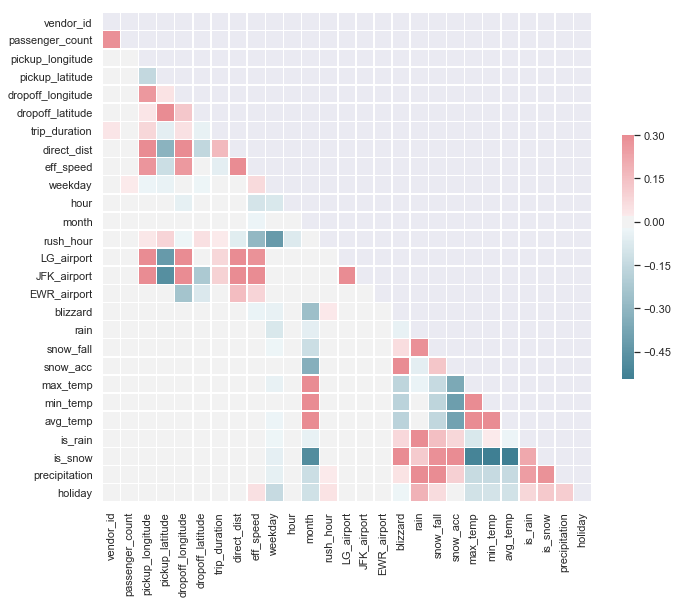

In [42]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
traincorr = trainfinal.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(traincorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(traincorr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


Hence, after removing a few features, we end up with the following "final" train set (note that "final" can be -and should be- tunned again after seeing model performance).

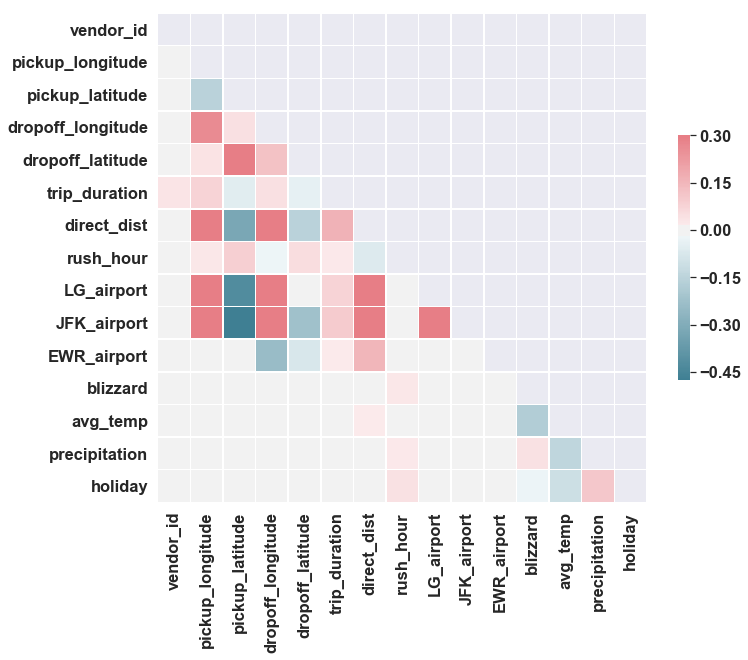

In [174]:
trainfinal2 = trainfinal
trainfinal2 = trainfinal2.drop(columns=['passenger_count','pickup_Dates','dropoff_Dates',\
                                        'eff_speed','weekday','hour','rain','snow_fall','snow_acc',\
                                        'max_temp','min_temp','month','is_rain','is_snow'])
traincorr2 = trainfinal2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(traincorr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.set(font_scale=1.5)
sns.heatmap(traincorr2, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Reviewing test set

At the beginning of this notebook, we already checked that there were no NAs nor NaNs in the test set. Here, we will check for outliers/artifacts on pick up and drop off locations.

In [44]:
test_latlon_pick = testdata[['pickup_latitude', 'pickup_longitude']].values # returns an array of 625134 rows
# https://pandas.pydata.org/pandas-docs/stable/indexing.html
# https://stackoverflow.com/questions/25876640/subsampling-every-nth-entry-in-a-numpy-array
test_latlon_pick_red = test_latlon_pick[0::200] # start:stop:step (sampling our data for display)

# https://www.kaggle.com/daveianhickey/how-to-folium-for-maps-heatmaps-time-analysis
# https://stackoverflow.com/questions/39401729/plot-latitude-longitude-points-from-dataframe-on-folium-map-ipython
testmapit = folium.Map( location=[testdata['pickup_latitude'].mean(), testdata['pickup_longitude'].mean()],
                   zoom_start=10 )

for coord in test_latlon_pick_red:
    folium.Marker(location=[coord[0], coord[1]]).add_to(testmapit)

testmapit.save( 'map_test_pick.html')

In the following map we can see that pick up locations are in agreement with the ones in train data set.

In [45]:
testmapit

In [46]:
test_latlon_drop = testdata[['dropoff_latitude', 'dropoff_longitude']].values # returns an array of 625134 rows
# https://pandas.pydata.org/pandas-docs/stable/indexing.html
# https://stackoverflow.com/questions/25876640/subsampling-every-nth-entry-in-a-numpy-array
test_latlon_drop_red = test_latlon_drop[0::200] # start:stop:step (sampling our data for display)

# https://www.kaggle.com/daveianhickey/how-to-folium-for-maps-heatmaps-time-analysis
# https://stackoverflow.com/questions/39401729/plot-latitude-longitude-points-from-dataframe-on-folium-map-ipython
testmapit_drop = folium.Map( location=[testdata['dropoff_latitude'].mean(), testdata['dropoff_longitude'].mean()],
                   zoom_start=10 )

for coord in test_latlon_drop_red:
    folium.Marker(location=[coord[0], coord[1]]).add_to(testmapit_drop)

testmapit_drop.save( 'map_test_drop.html')
testmapit_drop

Drop off locations are also coherent with those in train data set. Let's proceed now to compute direct distances for the test data set.

In [47]:
test_latlon_all = testdata[['pickup_latitude','pickup_longitude','dropoff_latitude', 'dropoff_longitude']].values

testdistances = [] # creating a list to store distance results
for coord in test_latlon_all:
    testdistances.append(geopy.distance.vincenty([coord[0], coord[1]], [coord[2], coord[3]]).km)

# Create a new column in the train data set from the list (distance in km)
testdata['direct_dist'] = testdistances

Checking mean and standard deviation for test data set distances.

In [48]:
test_direct_dist_mean = testdata['direct_dist'].mean()
test_direct_dist_std = testdata['direct_dist'].std()
print test_direct_dist_mean
print test_direct_dist_std
print trainclean['direct_dist'].mean()
print trainclean['direct_dist'].std()

3.43473061422
4.2756522867
3.51218846971
3.97785879672


Mean and standard deviation for test set data direct distance are in agreement with those obtained for the clean train set. Although, there seems to be a bit more of variability in the test data. Let's check for outliers in direct distance (remember that we defined a 200km threshold for this feature).

In [49]:
test_direct_dist_outliers = testdata['direct_dist'] > direct_dist_threshold # defined as 200 km
test_direct_dist_outliers.sum()

5

Surprisingly, we found 5 outliers. Let's check them on the map.

In [50]:
test_latlon_outliers = testdata.loc[test_direct_dist_outliers,['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].values

test_mapit_outliers = folium.Map( location=[testdata['dropoff_latitude'].mean(), traindata['dropoff_longitude'].mean()],
                   zoom_start=4 )
for coord in test_latlon_outliers:
    folium.Marker(location=[coord[0], coord[1]], icon=folium.Icon(color='blue')).add_to(test_mapit_outliers)
    folium.Marker(location=[coord[2], coord[3]], icon=folium.Icon(color='red')).add_to(test_mapit_outliers)

test_mapit_outliers.save( 'map_test_outliers.html')
test_mapit_outliers

For obvious reasons, I'm going to remove these outliers/artifacts from the test data set. Obviously, one needs to be very careful when manipulating test data sets, however, in this case the action is totally justified.

In [51]:
testclean = testdata
testclean = testclean[testclean.direct_dist <= direct_dist_threshold]
testclean.shape

(625129, 10)

### Computing and adding selected final features

Finally, we need to add the selected final features (as in train set): direct_dist, LG_airport, JFK_airport, rush_hour, blizzard, avg_temp, holiday, and precipitation. Note that first we'll need to transform datetimes to real timestamps as in train set.

In [52]:
# Converting pick up and drop off dates to datetime
testclean.loc[:,'pickup_Dates'] = pd.to_datetime(testclean['pickup_datetime'])
# Not worrying about the warning: 
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

testclean.head()

/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


id  vendor_id      pickup_datetime  passenger_count  \
0  id3004672          1  2016-06-30 23:59:58                1   
1  id3505355          1  2016-06-30 23:59:53                1   
2  id1217141          1  2016-06-30 23:59:47                1   
3  id2150126          2  2016-06-30 23:59:41                1   
4  id1598245          1  2016-06-30 23:59:33                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.988129        40.732029         -73.990173         40.756680   
1        -73.964203        40.679993         -73.959808         40.655403   
2        -73.997437        40.737583         -73.986160         40.729523   
3        -73.956070        40.771900         -73.986427         40.730469   
4        -73.970215        40.761475         -73.961510         40.755890   

  store_and_fwd_flag  direct_dist        pickup_Dates  
0                  N     2.742863 2016-06-30 23:59:58  
1                  N     2.755774 2016-06-30 23:59:53  
2                  N     1.307112 2016-06-30 23:59:47  
3                  N     5.266978 2016-06-30 23:59:41  
4                  N     0.961745 2016-06-30 23:59:33

In [53]:
# Rush hour
# Day of the week: Monday is 0 and Sunday is 6
testclean.loc[:,'weekday'] = testclean['pickup_Dates'].dt.dayofweek 
testclean.loc[:,'hour'] = testclean['pickup_Dates'].dt.hour
testclean.loc[:,'rush_hour'] = pd.Series(0, index=testclean.index)
mask = (testclean['weekday']<=4) & (testclean['hour']>=8) &(testclean['hour']<=18)
testclean.loc[mask, 'rush_hour'] = 1

# LG_airport and JFK_airport
# Looking for pick up locations within 3 km radius distance from these 2 airports
testclean_latlon_all = testclean[['pickup_latitude','pickup_longitude','dropoff_latitude', 'dropoff_longitude']].values

LGdistancesPU = [] # creating a list to store pick up distance from LG airport results
LGdistancesDO = [] # idem for drop off
JFKdistancesPU = []
JFKdistancesDO = []
EWRdistancesPU = []
EWRdistancesDO = []
for coord in testclean_latlon_all:
    LGdistancesPU.append(geopy.distance.vincenty([coord[0], coord[1]], [LG_location[0], LG_location[1]]).km)
    LGdistancesDO.append(geopy.distance.vincenty([coord[2], coord[3]], [LG_location[0], LG_location[1]]).km)
    JFKdistancesPU.append(geopy.distance.vincenty([coord[0], coord[1]], [JFK_location[0], JFK_location[1]]).km)
    JFKdistancesDO.append(geopy.distance.vincenty([coord[2], coord[3]], [JFK_location[0], JFK_location[1]]).km)
    EWRdistancesPU.append(geopy.distance.vincenty([coord[0], coord[1]], [EWR_location[0], EWR_location[1]]).km)
    EWRdistancesDO.append(geopy.distance.vincenty([coord[2], coord[3]], [EWR_location[0], EWR_location[1]]).km)
   
  
LGdistancesPU = np.array(JFKdistancesPU)
LGdistancesDO = np.array(LGdistancesDO)
JFKdistancesPU = np.array(JFKdistancesPU)
JFKdistancesDO = np.array(JFKdistancesDO)
EWRdistancesPU = np.array(EWRdistancesPU)
EWRdistancesDO = np.array(EWRdistancesDO)

testclean.loc[:,'LG_airport'] = pd.Series(0, index=testclean.index)
testclean.loc[:,'JFK_airport'] = pd.Series(0, index=testclean.index)
testclean.loc[:,'EWR_airport'] = pd.Series(0, index=testclean.index)

testclean.loc[LGdistancesPU <= radius,'LG_airport'] = 1
testclean.loc[JFKdistancesPU <= radius,'JFK_airport'] = 1
testclean.loc[EWRdistancesPU <= radius,'EWR_airport'] = 1
testclean.loc[LGdistancesDO <= radius,'LG_airport'] = 1
testclean.loc[JFKdistancesDO <= radius,'JFK_airport'] = 1
testclean.loc[EWRdistancesDO <= radius,'EWR_airport'] = 1

# blizzard, avg_temp, precipitationtrainclean['blizzard'] = pd.Series(0, index=trainclean.index)
testclean.loc[:,'blizzard'] = pd.Series(0, index=testclean.index)
testclean.loc[:,'rain'] = pd.Series(0, index=testclean.index)
testclean.loc[:,'snow_fall'] = pd.Series(0, index=testclean.index)
testclean.loc[:,'avg_temp'] = pd.Series(0, index=testclean.index)

for idx in weather.index:
    mask = (weather.loc[idx,'dateOK'].dayofyear == testclean['pickup_Dates'].dt.dayofyear)
    testclean.loc[mask, 'blizzard'] = weather.loc[idx,'blizzard']
    testclean.loc[mask, 'rain'] = weather.loc[idx,'rain']
    testclean.loc[mask, 'snow_fall'] = weather.loc[idx,'snow_fall']
    testclean.loc[mask, 'avg_temp'] = weather.loc[idx,'avg_temp']

testclean.loc[:,'precipitation'] = testclean['rain'] + testclean['snow_fall']


# holiday
testclean.loc[:,'holiday'] = pd.Series(0, index=testclean.index)

for fest in holidays:
    mask = (fest.dayofyear == testclean['pickup_Dates'].dt.dayofyear)
    testclean.loc[mask, 'holiday'] = 1

In [54]:
testfinal = testclean
testfinal = testfinal.drop(columns=['id','pickup_datetime','passenger_count','store_and_fwd_flag','pickup_Dates',\
                                    'weekday','hour','rain','snow_fall'])

In [55]:
list(testfinal)

['vendor_id',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'direct_dist',
 'rush_hour',
 'LG_airport',
 'JFK_airport',
 'EWR_airport',
 'blizzard',
 'avg_temp',
 'precipitation',
 'holiday']

In [56]:
list(trainfinal2)

['vendor_id',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'trip_duration',
 'direct_dist',
 'rush_hour',
 'LG_airport',
 'JFK_airport',
 'EWR_airport',
 'blizzard',
 'avg_temp',
 'precipitation',
 'holiday']

## Model
Choosing an algorithm and performing a prediction on trip duration for the test data set. XGBoost - eXtreme Gradient Boosting.

### Consistency check
We have already examined whether the two data sets (train and test) have the same spatio - temporal characteristics, this is: check pick up/drop off locations are in agreement between both data sets; check that number of pick ups per day follow the same distribution as train data set.

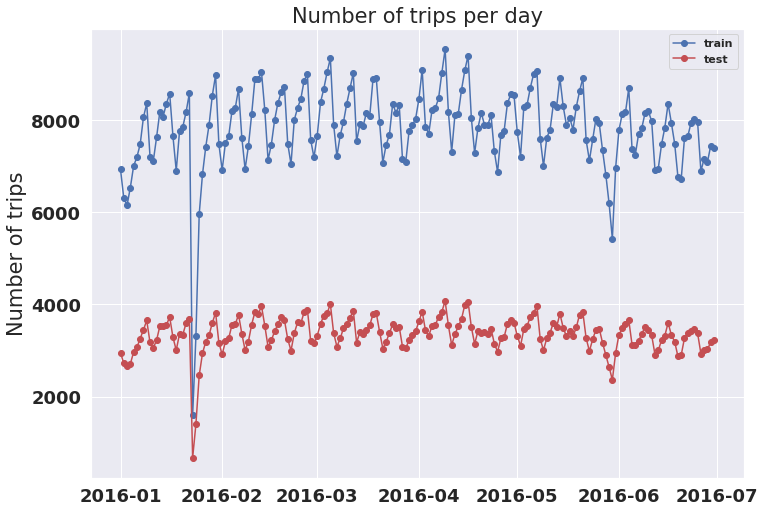

In [140]:
# Time series for number of pick ups per day, for both data sets. 
# Do they follow the same temporal pattern?

# Remember that 'id' contains a unique identifier of the trip
train_timeseries = trainclean.groupby([trainclean['pickup_Dates'].dt.date])['id'].count()
train_timeseries = train_timeseries.reset_index()
test_timeseries = testclean.groupby([trainclean['pickup_Dates'].dt.date])['id'].count()
test_timeseries = test_timeseries.reset_index()

matplotlib.rc('xtick', labelsize=18)     
matplotlib.rc('ytick', labelsize=18)

plt.plot(train_timeseries['pickup_Dates'], train_timeseries['id'], 'o-', color='b', label='train')
plt.plot(test_timeseries['pickup_Dates'], test_timeseries['id'], 'o-', color='r', label='test')
plt.title('Number of trips per day', fontsize=21)
plt.legend(loc=0)
plt.ylabel('Number of trips', fontsize=21)
plt.show()

We can see here how the total number of trips per day in train and test data sets follow the same temporal pattern. Thus showing consistency between both data sets.

### Evaluation
For this kaggle challenge the [evaluation metrics](https://www.kaggle.com/c/nyc-taxi-trip-duration#evaluation) is Root Mean Squared Logarithmic Error.

In [58]:
#from math import log
import xgboost as xgb
from sklearn.metrics import mean_squared_error
# Check this for a better insight into xgboost parameters
# https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

# Transforming the target to match the evaluation metric, i.e. take log(1+target), 
# then using the standard rmse of XGBoost.
trainfinal3 = trainfinal2
trainfinal3['trip_duration'] = np.log(trainfinal3['trip_duration'] + 1.0)

Due to XGBoost stopping the kernel (using python 2.17.14 and XGBoost 0.4.0 build string np19py27_0, both installed with Anaconda in a MacOS X 10.11.6) when executing xg_reg.predict function. I have saved the final clean train data set (trainfinal3) and the final clean test data set (testfinal) to csv files, and proceeded to apply the model in R. 

In [59]:
# Saving final train data set (with log(1+target)) and test data set to csv files, just in case
trainfinal3.to_csv('trainfinal3.csv')
testfinal.to_csv('testfinal.csv')
trainfinal3.head()

vendor_id  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          2        -73.982155        40.767937         -73.964630   
1          1        -73.980415        40.738564         -73.999481   
2          2        -73.979027        40.763939         -74.005333   
3          2        -74.010040        40.719971         -74.012268   
4          2        -73.973053        40.793209         -73.972923   

   dropoff_latitude  trip_duration  direct_dist  rush_hour  LG_airport  \
0         40.765602       6.122493     1.502172          1           0   
1         40.731152       6.498282     1.808660          0           0   
2         40.710087       7.661527     6.379687          1           0   
3         40.706718       6.063785     1.483632          0           0   
4         40.782520       6.077642     1.187038          0           0   

   JFK_airport  EWR_airport  blizzard   avg_temp  precipitation  holiday  
0            0            0         0   7.222222         22.606        0  
1            0            0         0  22.222222          0.000        0  
2            0            0         0  -4.166667          0.000        0  
3            0            0         0   2.222222          0.000        0  
4            0            0         0   5.833333          0.000        0

## XGBoost in Python 

I wanted to apply XGBoost algorithm as detailed in [submitted kernel by Heads or Tails kaggle user](https://www.kaggle.com/headsortails/nyc-taxi-eda-update-the-fast-the-curious) and [submitted kernel by karelrv kaggle user](https://www.kaggle.com/karelrv/nyct-from-a-to-z-with-xgboost-tutorial). However, XGBoost is killing the kernel when executed in python 2.17.14 and XGBoost 0.4.0 build string np19py27_0, both installed with Anaconda in a MacOS X 10.11.6. This has been documented [here](https://stackoverflow.com/questions/51164771/python-xgboost-kernel-died), [here](https://github.com/dmlc/xgboost/issues/1715), and [here](https://datascience.stackexchange.com/questions/33964/python-xgboost-killing-kernel) (same question, different answers). I could not manage to solve this issue in my system. I just add the python code that should be executed here, and add the solution in R at the bottom.


In [ ]:
#import pandas as pd
#import numpy as np
#import scipy as sp
#import math
#import matplotlib
import matplotlib.pyplot as plt

# Fixing a bug that causes xgboost to kill the kernel in jupyter notebook on MacOS
# https://datascience.stackexchange.com/questions/33964/python-xgboost-killing-kernel
# https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

PREtrainfinal3 = pd.read_csv("trainfinal3.csv")
PREtestfinal = pd.read_csv("testfinal.csv")

PREtrainfinal3.head()

In [ ]:
trainfinal3 = PREtrainfinal3.iloc[:,1:15]
testfinal = PREtestfinal.iloc[:,1:15]

testfinal.head()

In [ ]:
# Separating the target variable and rest of the variables using .iloc to subset the data.
# target variable: trip_duration (= y)
y = trainfinal3.iloc[:,5] # trip_duration corresponds to column 5 (column indexes start at 0)
# rest of features (= X)
X = trainfinal3.drop('trip_duration', axis=1)

# Converting the dataset into an optimized data structure called Dmatrix. This data structure
# is supported by XGBoost and provides improved performance and efficiency. 
data_dmatrix = xgb.DMatrix(data=X,label=y)
# Converting also the final test data set to Dmatrix
test_dmatrix = xgb.DMatrix(data=testfinal)

# Cross validation
# https://www.datacamp.com/community/tutorials/xgboost-in-python
from sklearn.model_selection import train_test_split

# Splitting final train data set (X,y) into 80/20 fractions using train_test_split function. Hence,
# test_size=0.2. In order to ensure reproducibility of results, specifying a seed for the random
# number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Hyper-parameters for XGBRegressor:
#
# objective -> ='reg:linear': for regression problems (determines the loss function to be used)
# colsample_bytree -> = 0.3 - 0.7: percentage of features used per tree. High value can lead to overfitting
# learning_rate -> = 0.1: step size shrinkage used to prevent overfitting. Range is [0,1]
# max_depth -> = 5: determines how deeply each tree is allowed to grow during any boosting round
# n_estimators -> = 10: number of trees you want to build
#
# Regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models
# alpha -> = 10: L1 regularization on leaf weights. A large value leads to more regularization
#
#xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, n_estimators = 10) # CHECK n_jobs=-1 (https://www.kaggle.com/nitin194/nyc-taxi-trip-duration-prediction)

# max_depth = 10,30,50 from https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db
# n_estimators = 200

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

In [ ]:
# k-fold cross validation
#params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}
params = {'objective':'reg:linear','colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5}

#cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=50,early_stopping_rounds=10,\
#                    metrics='rmse', as_pandas=True, seed=123)
# Issue with xgb.cv parameters:
# https://github.com/dmlc/xgboost/issues/1044
# Should download last version from github and compile it myself (I have no time for this right now)

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=15, metrics='rmse', seed=123)

# num_boost_round=50-60 (this would take a lot of computing time, check first with 15)
# nfold=5

cv_results.head()

print((cv_results['test-rmse-mean']).tail(1))

#  You may consider applying techniques like Grid Search, Random Search and Bayesian Optimization 
# to reach the optimal set of hyper-parameters.

In [ ]:
# Examining the importance of each feature column in the original dataset within the model
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [ ]:
# Finally, apply the XGBoost model to predict trip duration for the test data set
test_preds = xg_reg.predict(testfinal)

test_preds
# PENDING: write a submission file according to competition specifications
#
# pred <- test_id %>%
#
#  mutate(trip_duration = exp(test_preds) - 1)
#
# pred %>% write_csv('submit.csv')

# Nice to have: compute trip_duration distribution (histogram) for train data set (final one) and 
# the predicted trip_duration histogram for test data set.

## XGBoost in R

Due to what there seems to be a bug in XGBoost in python in MacOS, I trained the model, checked its accuracy, and performed my prediction in R.

```
# From https://www.kaggle.com/headsortails/nyc-taxi-eda-update-the-fast-the-curious

library('ggplot2') # visualisation
library('scales') # visualisation
library('grid') # visualisation
library('RColorBrewer') # visualisation
library('dplyr') # data manipulation
library('readr') # input/output
library('data.table') # data manipulation
library('tibble') # data wrangling
library('tidyr') # data wrangling
library('stringr') # string manipulation
library('forcats') # factor manipulation
library('xgboost') # modelling
library('caret') # modelling
library('magrittr') # function "%>%"
library('plotly')

setwd("/Users/marta/Dropbox/DataScience/JobHunting/AIA/Kaggle_NYCTaxiTripDuration")

trainfinal <- read.csv("/Users/marta/Dropbox/DataScience/JobHunting/AIA/Kaggle_NYCTaxiTripDuration/trainfinal3.csv")
trainfinal <- trainfinal[-1]
# Note that for trainfinal, 'trip_duration' is already in the format log(trip_duration +1) to
# comply with the evaluation metrics
testfinal <- read.csv("/Users/marta/Dropbox/DataScience/JobHunting/AIA/Kaggle_NYCTaxiTripDuration/testfinal.csv")
testfinal <- testfinal[-1]

# Specific definitions:
#---------------------------------
# predictor features

train_cols <- c("direct_dist", "rush_hour", "vendor_id", "EWR_airport",
                "JFK_airport", "LG_airport", "dropoff_longitude",
                "dropoff_latitude", "pickup_longitude", "pickup_latitude",
                "blizzard","avg_temp","precipitation")

y_col <- c("trip_duration")

cols <- c(train_cols, y_col)

#---------------------------------

# Cross validation step
set.seed(134)
trainIndex <- createDataPartition(trainfinal$trip_duration, p = 0.8, list = FALSE, times = 1)
train <- trainfinal[trainIndex,]
valid <- trainfinal[-trainIndex,]

# Reformatting data to feed XGBoost algorithm
foo <- train %>% select(-trip_duration)
bar <- valid %>% select(-trip_duration)

dtrain <- xgb.DMatrix(as.matrix(foo),label = train$trip_duration)
dvalid <- xgb.DMatrix(as.matrix(bar),label = valid$trip_duration)
dtest <- xgb.DMatrix(as.matrix(testfinal))

# Defining XGBoost hyper-parameters
xgb_params <- list(colsample_bytree = 0.7, #variables per tree 
                   subsample = 0.7, #data subset per tree 
                   booster = "gbtree",
                   max_depth = 5, #tree levels
                   eta = 0.3, #shrinkage
                   eval_metric = "rmse", 
                   objective = "reg:linear",
                   seed = 4321
                   )

watchlist <- list(train=dtrain, valid=dvalid)

# Training the classifier
set.seed(134)
gb_dt <- xgb.train(params = xgb_params,
                   data = dtrain,
                   print_every_n = 5,
                   watchlist = watchlist,
                   nrounds = 60)
```
> [1]	train-rmse:4.250701	valid-rmse:4.251657 

> [6]	train-rmse:0.825171	valid-rmse:0.826357 

> [11]	train-rmse:0.426951	valid-rmse:0.428910 

> [16]	train-rmse:0.404909	valid-rmse:0.407148 

> [21]	train-rmse:0.401226	valid-rmse:0.403716 

> [26]	train-rmse:0.399415	valid-rmse:0.402071 

> [31]	train-rmse:0.397212	valid-rmse:0.400016 

> [36]	train-rmse:0.394797	valid-rmse:0.397773 

> [41]	train-rmse:0.393925	valid-rmse:0.397032 

> [46]	train-rmse:0.393186	valid-rmse:0.396499 

> [51]	train-rmse:0.391940	valid-rmse:0.395380 

> [56]	train-rmse:0.391218	valid-rmse:0.394788 

> [60]	train-rmse:0.390987	valid-rmse:0.394670 

```
# Cross validation
# Due to running time constrains, setting nrounds=15 (should be ~100!!!)
xgb_cv <- xgb.cv(xgb_params,dtrain,early_stopping_rounds = 10, nfold = 5, nrounds=15)
```
> [1]	train-rmse:4.250671+0.000161	test-rmse:4.250665+0.000881 
> Multiple eval metrics are present. Will use test_rmse for early stopping.
> Will train until test_rmse hasn't improved in 10 rounds.
> 
> [2]	train-rmse:2.991022+0.000149	test-rmse:2.991033+0.000793 

> [3]	train-rmse:2.115379+0.000134	test-rmse:2.115412+0.000841 

> [4]	train-rmse:1.510937+0.000128	test-rmse:1.510976+0.000833 

> [5]	train-rmse:1.099037+0.000124	test-rmse:1.099134+0.000883 

> [6]	train-rmse:0.824706+0.000183	test-rmse:0.824852+0.000876 

> [7]	train-rmse:0.648713+0.000342	test-rmse:0.648968+0.000916

> [8]	train-rmse:0.541472+0.000281	test-rmse:0.541824+0.001048 

> [9]	train-rmse:0.479479+0.000173	test-rmse:0.479908+0.001180 

> [10]	train-rmse:0.445670+0.000199	test-rmse:0.446160+0.001227 

> [11]	train-rmse:0.427128+0.000423	test-rmse:0.427683+0.001275 

> [12]	train-rmse:0.417166+0.000639	test-rmse:0.417769+0.001205 

> [13]	train-rmse:0.411269+0.000477	test-rmse:0.411937+0.001180 

> [14]	train-rmse:0.408154+0.000451	test-rmse:0.408849+0.001074

> [15]	train-rmse:0.406414+0.000532	test-rmse:0.407168+0.001012

Hence, local RMSLE score is around 0.41. A perfect prediction would have RMSLE = 0. At today's date, *if final kaggle score for this kernel is similar to this local one* that would mean to be around the top 40% of submissions in this kaggle challenge. There is clearly a lot of room for improvement: 
- increasing the number of rounds for the training and cross validating steps
- adding new features, and checking the impact of performed data cleaning
- fine tuning XGBoost hyper-parameters
- it would also be worth to explore other regression algorithms, maybe Random Forest could be a good candidate.

```
# Feature importance
imp_matrix <- as.tibble(xgb.importance(feature_names = colnames(train %>% select(-trip_duration)), model = gb_dt))

imp_matrix %>%
  ggplot(aes(reorder(Feature, Gain, FUN = max), Gain, fill = Feature)) +
  geom_col() +
  coord_flip() +
  theme(legend.position = "none") +
  labs(x = "Features", y = "Importance")
```
<img src="feature_importance_XGBoost_R.png">

```
# Predicting trip durations for testfinal data set
test_preds <- predict(gb_dt,dtest)
# Physical time, in seconds
pred_trip_duration <- exp(test_preds) - 1
phys_train_trip_duration <- exp(trainfinal$trip_duration) -1

# Plot histograms and compare them
# Overlaying histograms - Histogram Colored (blue and red)
# https://www.r-bloggers.com/overlapping-histogram-in-r/
hist(phys_train_trip_duration/60, col=rgb(1,0,0,0.5),
     xlim=c(0,60), ylim=c(0,0.08),
     main="Histogram for NYC taxi trip duration", xlab="Trip duration (min)",
     breaks=1000, prob = TRUE) 
hist(pred_trip_duration/60, col=rgb(0,0,1,0.5), breaks=100, prob = TRUE, add=T)  
legend("topright", c("train", "test prediction"), fill=c(rgb(1,0,0,0.5), rgb(0,0,1,0.5)))
box()
```
<img src="train_test_trip_durations_histograms.png">

It appears that the predicted trip durations for the test data set presents the same distribution as the trip duration for the train data set. 

```
# https://datascienceplus.com/standard-deviation-vs-standard-error/
# Standard Error of the Mean (SEM)
mean(phys_train_trip_duration/60)
```
> \[1\] 16.15975

```
sd(phys_train_trip_duration/60)/sqrt(length(phys_train_trip_duration/60))
```
> \[1\] 0.04458809

```
mean(pred_trip_duration/60)
```
> \[1\] 13.39069

```
sd(pred_trip_duration/60)/sqrt(length(pred_trip_duration/60))
```
> \[1\] 0.01157046

There are, of course, severals ways in which this prediction could be improved: 

- increasing the number of rounds for training and cross validation
- fine tuning XGBoost hyper-parameters
- adding flag feature and number of passengers
- adding new features: directionality, "fastest" real distances (computed using fastest real routes)